# CS3920 - Machine Learning

Assignment 1

In [1]:
# Imports
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

## 1 - Load Each Dataset Into Python

In [2]:
# Load each dataset.
iris = load_iris()
ionosphere = np.genfromtxt('ionosphere.txt', delimiter=',')

## 2 - Split Datasets Into Training and Test Sets

In [3]:
# Split each dataset into training and test sets.
iris_train_data, iris_test_data, iris_train_labels, iris_test_labels = train_test_split(
    iris['data'], iris['target'], random_state=2311
)
ionosphere_train_data, ionosphere_test_data, ionosphere_train_labels, ionosphere_test_labels = train_test_split(
    ionosphere[:, :-1], ionosphere[:, -1], random_state=2311
)

## 3 - Implement Nearest Neighbour and Calculate Test Error Rate

In [4]:
# Nearest Neighbour.
def nearest_neighbour(training_data, training_labels, sample_data):
    min_distance = np.inf
    
    # Calculate the minimum distance and its predicted label.
    for i, test_sample in enumerate(training_data):
        distance = np.sqrt(np.sum(np.square(test_sample - sample_data)))
        if distance < min_distance:
            min_distance = distance
            predicted_label = training_labels[i]
    
    return predicted_label


# Calculates NN Error Rate.
def NN_error_rate(training_data, training_labels, test_data, test_labels):
    
    # Collects and compares the number of incorrect predictions against total predictions.
    predictions = np.array([nearest_neighbour(training_data, training_labels, test_sample) for test_sample in test_data])
    incorrect_predictions = np.sum(predictions != test_labels)
    error_rate = (incorrect_predictions / np.size(test_labels)) * 100

    return error_rate


# Using NN algorithm w/ Datasets.
NN_iris_error = NN_error_rate(iris_train_data, iris_train_labels,
                                iris_test_data, iris_test_labels)
NN_ionosphere_error = NN_error_rate(ionosphere_train_data, ionosphere_train_labels,
                                      ionosphere_test_data, ionosphere_test_labels)


print("NN Test Error Rates:\n")
print("Iris Correct - ", 100 - NN_iris_error, "%")
print("Iris Incorrect - ", NN_iris_error, "%")
print("Ionosphere Correct - ", 100 - NN_ionosphere_error, "%")
print("Ionosphere Incorrect - ", NN_ionosphere_error, "%")

NN Test Error Rates:

Iris Correct -  94.73684210526316 %
Iris Incorrect -  5.263157894736842 %
Ionosphere Correct -  85.22727272727272 %
Ionosphere Incorrect -  14.772727272727273 %


## 4 - Implement Conformal Predictor Based on the NN Conformity Measure

In [5]:
# Conformal Predictor.
def conformal_predictor(training_data, training_labels, test_data):
    
    conformity_measures = []
    
    for sample in test_data:
        
        # Collect the distances from the test sample to each of the training samples.
        distances = []
        for training_sample in training_data:
            distance = np.sqrt(np.sum(np.square(training_sample - sample)))
            distances.append(distance)
            
        # Get the indices of the array if it were sorted.
        sorted_indices = np.argsort(distances)
        same_class_nearest = sorted_indices[0]
        differnet_class_nearest = None
        
        # Get the next nearest neighbour of a different class.
        for i in range(1, len(sorted_indices)):
            if distances[sorted_indices[i]] != distances[same_class_nearest]:
                differnet_class_nearest = sorted_indices[i]
                break
                
        # Calculate the conformity measure.
        if differnet_class_nearest is None or (distances[differnet_class_nearest] > 0 and distances[same_class_nearest] == 0):
            conformity_measure = np.inf
        elif (distances[differnet_class_nearest] == 0) and (distances[same_class_nearest] == 0):
            conformity_measure = 0
        else:  
            conformity_measure = distances[differnet_class_nearest] / distances[same_class_nearest]
        conformity_measures.append(conformity_measure)
    
    # Rank in order of conformity measure.
    conformity_measures = np.array(conformity_measures)
    ranks = np.argsort(conformity_measures)

    # Calculate p-values based on ranks
    p_values = (ranks + 1) / (len(conformity_measures) + 1)
    
    predictions = ~(p_values < 0.05)
    
    return predictions

def avg_false_p_values(training_data, training_labels, test_data):
    predictions = conformal_predictor(training_data, training_labels, test_data)
    average_false_p_values = np.mean(predictions == False) * 100
    return average_false_p_values

iris_false_p_values = avg_false_p_values(iris_train_data, iris_train_labels, iris_test_data)
ionosphere_false_p_values = avg_false_p_values(ionosphere_train_data, ionosphere_train_labels, ionosphere_test_data)

print("Average False P Values:\n")
print("Iris -", iris_false_p_values, "%")
print("Ionosphere -", ionosphere_false_p_values, "%")

Average False P Values:

Iris - 2.631578947368421 %
Ionosphere - 4.545454545454546 %


## 5 - Report and Discussion

#### Test Error Rate for Nearest Neighbour:
    Iris Success: 94.74% (94.73684210526316%)
    Iris Failure: 5.26%  (5.263157894736842%)
    
    Ionosphere Success: 85.23% (85.22727272727272%)
    Ionosphere Failure: 14.77% (14.772727272727273%)

#### Average False p-value for the NN Conformal Predictor:
    Iris: 2.63% (2.631578947368421%)
    Ionosphere: 4.55% (4.545454545454546%)

## Optional Additions

### Implement K-Nearest Neighbour

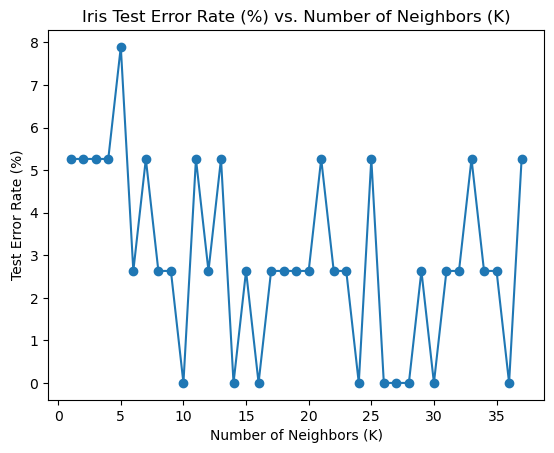

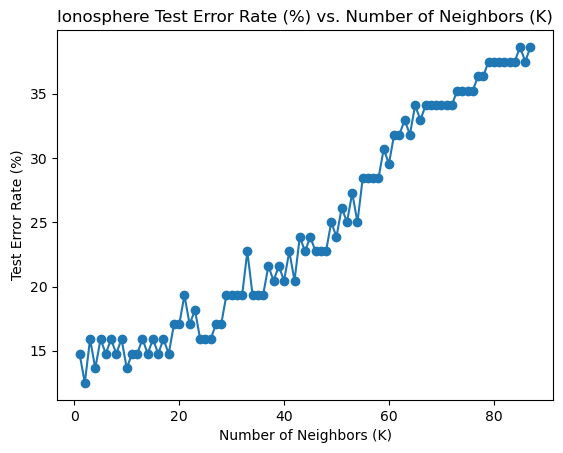

In [6]:
# K-Nearest Neighbour.
def K_nearest_neighbour(training_data, training_labels, test_sample, k_value):
    
    # Collect the distances from the test sample to each of the training samples.
    distances = []
    for i, training_sample in enumerate(training_data):
        distance = np.sqrt(np.sum(np.square(training_sample - test_sample)))
        distances.append(distance)
    
    # Only select the first K closest labels.
    k_nearest = np.argsort(distances)[:k_value]
    k_labels = training_labels[k_nearest]
    
    # Implement majority voting to find the most common label.
    unique_labels, counts = np.unique(k_labels, return_counts=True)
    max_count_index = np.argmax(counts)
    majority_label = unique_labels[max_count_index]

    return majority_label


# Calulates KNN Error Rate.
def KNN_error_rate(training_data, training_labels, test_data, test_labels, k_value):
    
    # Collects and compares the number of incorrect predictions against total predictions.
    predictions = np.array([K_nearest_neighbour(training_data, training_labels, test_sample, k_value) for test_sample in test_data])
    incorrect_predictions = np.sum(predictions != test_labels)
    error_rate = (incorrect_predictions / np.size(test_labels)) * 100

    return error_rate


# Using KNN for all K in datasets.
KNN_iris_error = np.array([KNN_error_rate(iris_train_data, iris_train_labels,
                                iris_test_data, iris_test_labels, k) for k in range(1, np.size(iris_test_labels))])
KNN_ionosphere_error = np.array([KNN_error_rate(ionosphere_train_data, ionosphere_train_labels,
                                ionosphere_test_data, ionosphere_test_labels, k) for k in range(1, np.size(ionosphere_test_labels))])

plt.plot(range(1, np.size(iris_test_labels)), KNN_iris_error, marker='o')
plt.title('Iris Test Error Rate (%) vs. Number of Neighbors (K)')
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Test Error Rate (%)')
plt.show()

plt.plot(range(1, np.size(ionosphere_test_labels)), KNN_ionosphere_error, marker='o')
plt.title('Ionosphere Test Error Rate (%) vs. Number of Neighbors (K)')
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Test Error Rate (%)')
plt.show()